<a href="https://colab.research.google.com/github/Thomas-George-T/Streamlit-YouTube-Dashboard/blob/main/YouTube_EDA_%26_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YouTube NLP

## Ingesting Comments from the YouTube Video

In [1]:
api_key = ''

In [2]:
from googleapiclient.discovery import build

# The string after v=? in the url
video_id = "Il0S8BoucSA"

# creating youtube resource object
youtube = build('youtube', 'v3',
developerKey=api_key)

# retrieve youtube video results
video_response=youtube.commentThreads().list(
  part='snippet',
  maxResults=200,
  order='relevance',
  videoId=video_id
).execute()

## Data Preprocessing

### Data Wrangling

#### Assumptions


*   Picking only the comment made by the original author
  *   Comment Threads on the Original Authors comment could be diverging from the video
  *   Limiting Response to about 10 for testing

*   Using the 'textOriginal' instead of 'textDisplay' for easier cleanup of the comment


*   Analyzing only English Comments 
  *   Storing the number of non English comments for metrics








In [3]:
# empty list for storing reply
comments = []

# extracting required info from each result object
for item in video_response['items']:

  # Extracting comments
  comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
  # Extracting author
  author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
  # Extracting published time
  published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']
  # Extracting likes
  like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
  # Extracting total replies to the comment
  reply_count = item['snippet']['totalReplyCount']

  comments.append([author, comment, published_at, like_count, reply_count])

In [4]:
len(comments)

100

Test with Pandas

In [5]:
comments[0:5]

[['Savita Pathak',
  'How can Ed always give us a masterpiece?? \nI literally heard it more than 50 times.',
  '2021-09-15T07:58:19Z',
  219,
  4],
 ['ELECTRO CENTRAL MUSIC',
  'Uma das melhores músicas dos últimos anos. Que ritmo senacional!',
  '2023-08-10T01:34:51Z',
  35,
  0],
 ['Roblox girls',
  'i love this song huge fan of it thanks for making it me and my friends dance to it all the time!😸😸😺',
  '2023-10-03T21:25:45Z',
  1,
  0],
 ['NB Musica En Ingles',
  '*Como não tem mais reconhecimento esta grande música?*',
  '2023-08-18T17:31:19Z',
  43,
  0],
 ['Bruna de Jesus',
  'Amando essa música!!!!!!!!!!!!🤩🤩🥰🥰',
  '2023-09-03T05:34:13Z',
  10,
  0]]

### NLP

#### Install Libraries

In [6]:
pip install Unidecode

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install clean-text

Note: you may need to restart the kernel to use updated packages.


#### Text Processing

In [10]:
len(comments)

100

In [11]:
import pandas as pd
df = pd.DataFrame({'Author': [i[0] for i in comments], 'Comment': [i[1] for i in comments], 'Timestamp': [i[2] for i in comments],
                  'Likes': [i[3] for i in comments], 'TotalReplies': [i[4] for i in comments]})

In [12]:
df.head()

,Author,Comment,Timestamp,Likes,TotalReplies
0,Savita Pathak,How can Ed always give us a masterpiece?? \nI ...,2021-09-15T07:58:19Z,219,4
1,ELECTRO CENTRAL MUSIC,Uma das melhores músicas dos últimos anos. Que...,2023-08-10T01:34:51Z,35,0
2,Roblox girls,i love this song huge fan of it thanks for mak...,2023-10-03T21:25:45Z,1,0
3,NB Musica En Ingles,*Como não tem mais reconhecimento esta grande ...,2023-08-18T17:31:19Z,43,0
4,Bruna de Jesus,Amando essa música!!!!!!!!!!!!🤩🤩🥰🥰,2023-09-03T05:34:13Z,10,0


In [13]:
from cleantext import clean

# Remove extra spaces and make them lower case. Replace special emojis
clean_df = df
clean_df['Comment'] = clean_df['Comment'].apply(lambda x: x.strip().lower().replace('xd','').replace('<3',''))

# Clean text from line breaks, unicodes, emojis and punctuations
clean_df['Comment'] = clean_df['Comment'].apply(lambda x: clean(x, no_emoji=True, no_punct=True, no_line_breaks=True, fix_unicode=True))
clean_df.head()

,Author,Comment,Timestamp,Likes,TotalReplies
0,Savita Pathak,how can ed always give us a masterpiece i lite...,2021-09-15T07:58:19Z,219,4
1,ELECTRO CENTRAL MUSIC,uma das melhores musicas dos ultimos anos que ...,2023-08-10T01:34:51Z,35,0
2,Roblox girls,i love this song huge fan of it thanks for mak...,2023-10-03T21:25:45Z,1,0
3,NB Musica En Ingles,como nao tem mais reconhecimento esta grande m...,2023-08-18T17:31:19Z,43,0
4,Bruna de Jesus,amando essa musica,2023-09-03T05:34:13Z,10,0


In [14]:
display(clean_df['Comment'])

0     how can ed always give us a masterpiece i lite...
1     uma das melhores musicas dos ultimos anos que ...
2     i love this song huge fan of it thanks for mak...
3     como nao tem mais reconhecimento esta grande m...
4                                    amando essa musica
                            ...                        
95    ed is amazing person just happy that we can se...
96                                            very good
97    a message for future generations dont let this...
98                    fun fact this song never gets old
99                                          spectacular
Name: Comment, Length: 100, dtype: object

In [15]:
from langdetect import detect, LangDetectException
def det_lang(language):
    """ Function to detect language
    Args:
        Language column from the dataframe
    Returns:
        Detected Language or Other
    """
    try:
        lang = detect(language)
    except LangDetectException:
        lang = 'Other'
    return lang

In [16]:
clean_df['Language'] = clean_df['Comment'].apply(det_lang)
clean_df.head()

,Author,Comment,Timestamp,Likes,TotalReplies,Language
0,Savita Pathak,how can ed always give us a masterpiece i lite...,2021-09-15T07:58:19Z,219,4,en
1,ELECTRO CENTRAL MUSIC,uma das melhores musicas dos ultimos anos que ...,2023-08-10T01:34:51Z,35,0,pt
2,Roblox girls,i love this song huge fan of it thanks for mak...,2023-10-03T21:25:45Z,1,0,en
3,NB Musica En Ingles,como nao tem mais reconhecimento esta grande m...,2023-08-18T17:31:19Z,43,0,pt
4,Bruna de Jesus,amando essa musica,2023-09-03T05:34:13Z,10,0,pt


In [17]:
import pycountry
# Convert ISO country codes to Languages
clean_df['Language'] = clean_df['Language'].apply(lambda x: pycountry.languages.get(alpha_2=x).name if(x) != 'Other' else 'Not-Detected')
clean_df.head()

,Author,Comment,Timestamp,Likes,TotalReplies,Language
0,Savita Pathak,how can ed always give us a masterpiece i lite...,2021-09-15T07:58:19Z,219,4,English
1,ELECTRO CENTRAL MUSIC,uma das melhores musicas dos ultimos anos que ...,2023-08-10T01:34:51Z,35,0,Portuguese
2,Roblox girls,i love this song huge fan of it thanks for mak...,2023-10-03T21:25:45Z,1,0,English
3,NB Musica En Ingles,como nao tem mais reconhecimento esta grande m...,2023-08-18T17:31:19Z,43,0,Portuguese
4,Bruna de Jesus,amando essa musica,2023-09-03T05:34:13Z,10,0,Portuguese


In [18]:
clean_df.count()

Author          100
Comment         100
Timestamp       100
Likes           100
TotalReplies    100
Language        100
dtype: int64

In [19]:
clean_df.drop(clean_df[clean_df['Language'] == 'Not-Detected'].index, inplace = True)

## Text Blob


In [20]:
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize
# New variable for TextBlob approach
textBlob = clean_df.loc[clean_df['Language']=='English']

def get_polarity(text):
  return TextBlob(text).sentiment.polarity

textBlob['TextBlob_Polarity'] = textBlob['Comment'].apply(get_polarity)

/var/folders/qf/9lg8vbt12270lh6bbvv2t0940000gn/T/ipykernel_89637/1530850154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textBlob['TextBlob_Polarity'] = textBlob['Comment'].apply(get_polarity)


In [21]:
textBlob['TextBlob_Sentiment_Type']=''
textBlob.loc[textBlob.TextBlob_Polarity>0,'TextBlob_Sentiment_Type']='POSITIVE'
textBlob.loc[textBlob.TextBlob_Polarity==0,'TextBlob_Sentiment_Type']='NEUTRAL'
textBlob.loc[textBlob.TextBlob_Polarity<0,'TextBlob_Sentiment_Type']='NEGATIVE'

/var/folders/qf/9lg8vbt12270lh6bbvv2t0940000gn/T/ipykernel_89637/2719581564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textBlob['TextBlob_Sentiment_Type']=''


In [22]:
textBlob.TextBlob_Sentiment_Type.value_counts()

POSITIVE    56
NEUTRAL      5
NEGATIVE     2
Name: TextBlob_Sentiment_Type, dtype: int64

<Axes: title={'center': 'TextBlob Sentiment Analysis'}>

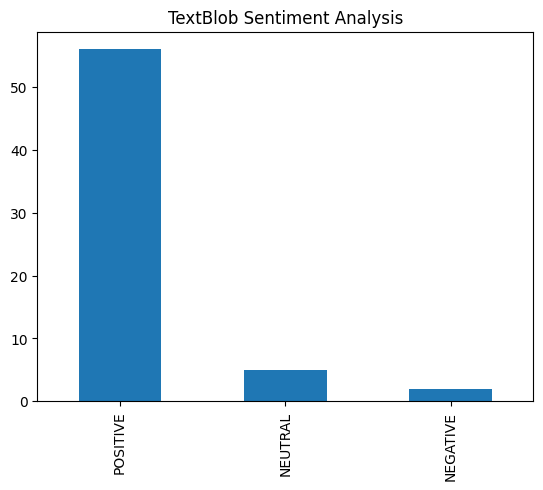

In [23]:
textBlob.TextBlob_Sentiment_Type.value_counts().plot(kind='bar',title="TextBlob Sentiment Analysis")

## Vader

In [24]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader_df = clean_df.loc[clean_df['Language']=='English']

sid = SentimentIntensityAnalyzer()

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [25]:
vader_df['vader_scores'] = vader_df['Comment'].apply(lambda Comment: sid.polarity_scores(Comment))
vader_df.head()

/var/folders/qf/9lg8vbt12270lh6bbvv2t0940000gn/T/ipykernel_89637/3437287351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_df['vader_scores'] = vader_df['Comment'].apply(lambda Comment: sid.polarity_scores(Comment))


,Author,Comment,Timestamp,Likes,TotalReplies,Language,vader_scores
0,Savita Pathak,how can ed always give us a masterpiece i lite...,2021-09-15T07:58:19Z,219,4,English,"{'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compou..."
2,Roblox girls,i love this song huge fan of it thanks for mak...,2023-10-03T21:25:45Z,1,0,English,"{'neg': 0.0, 'neu': 0.519, 'pos': 0.481, 'comp..."
5,Sulatha Gengatharan,perfection whenever i feel bored or tired i ju...,2023-06-04T19:38:10Z,123,2,English,"{'neg': 0.17, 'neu': 0.443, 'pos': 0.387, 'com..."
6,Saksham Chaturvedi,never have i ever listened to an ed sheeran so...,2021-11-02T09:19:58Z,408,9,English,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
10,Bunny Mix Lyrics,i love this song good job ed for making everyo...,2023-09-20T04:26:45Z,5,0,English,"{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp..."


In [26]:
vader_df['compound'] = vader_df['vader_scores'].apply(lambda score_dict: score_dict['compound'])
vader_df['vader_sentiment_type']=''
vader_df.loc[vader_df.compound>0,'vader_sentiment_type']='POSITIVE'
vader_df.loc[vader_df.compound==0,'vader_sentiment_type']='NEUTRAL'
vader_df.loc[vader_df.compound<0,'vader_sentiment_type']='NEGATIVE'

/var/folders/qf/9lg8vbt12270lh6bbvv2t0940000gn/T/ipykernel_89637/231554778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_df['compound'] = vader_df['vader_scores'].apply(lambda score_dict: score_dict['compound'])
/var/folders/qf/9lg8vbt12270lh6bbvv2t0940000gn/T/ipykernel_89637/231554778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vader_df['vader_sentiment_type']=''


In [27]:
vader_df.vader_sentiment_type.value_counts()

POSITIVE    58
NEUTRAL      3
NEGATIVE     2
Name: vader_sentiment_type, dtype: int64

<Axes: title={'center': 'sentiment analysis'}>

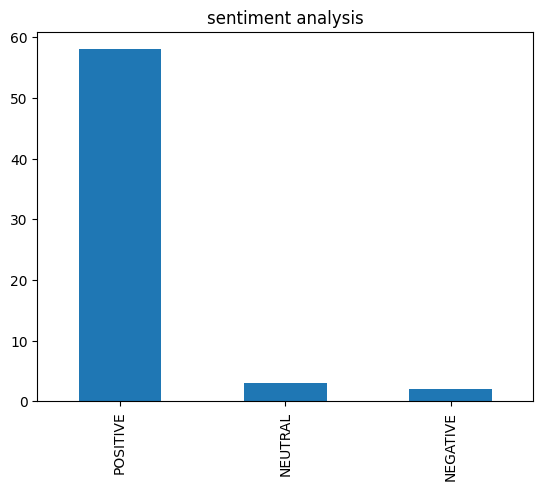

In [28]:
vader_df.vader_sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

## Comparison

In [29]:
vader_df.groupby(['vader_sentiment_type']).head()

,Author,Comment,Timestamp,Likes,TotalReplies,Language,vader_scores,compound,vader_sentiment_type
0,Savita Pathak,how can ed always give us a masterpiece i lite...,2021-09-15T07:58:19Z,219,4,English,"{'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compou...",0.6249,POSITIVE
2,Roblox girls,i love this song huge fan of it thanks for mak...,2023-10-03T21:25:45Z,1,0,English,"{'neg': 0.0, 'neu': 0.519, 'pos': 0.481, 'comp...",0.9300,POSITIVE
5,Sulatha Gengatharan,perfection whenever i feel bored or tired i ju...,2023-06-04T19:38:10Z,123,2,English,"{'neg': 0.17, 'neu': 0.443, 'pos': 0.387, 'com...",0.8096,POSITIVE
6,Saksham Chaturvedi,never have i ever listened to an ed sheeran so...,2021-11-02T09:19:58Z,408,9,English,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
10,Bunny Mix Lyrics,i love this song good job ed for making everyo...,2023-09-20T04:26:45Z,5,0,English,"{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp...",0.8750,POSITIVE
11,doglover smith,ed is killing it everything he does is remarka...,2023-05-26T01:03:05Z,58,0,English,"{'neg': 0.138, 'neu': 0.439, 'pos': 0.423, 'co...",0.8434,POSITIVE
41,Krystina Bouchard,i absolutely cant get enough of this song,2023-04-16T01:54:32Z,8,1,English,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
44,Phil Grossman,definitely my favourite ed sheeran song and wi...,2023-06-04T22:48:43Z,33,0,English,"{'neg': 0.092, 'neu': 0.82, 'pos': 0.089, 'com...",-0.0258,NEGATIVE
76,Accord Electronic Music,ed can you ever disappoint track is fire,2023-09-15T11:10:42Z,2,0,English,"{'neg': 0.459, 'neu': 0.541, 'pos': 0.0, 'comp...",-0.6249,NEGATIVE
84,ikobobisking,2 years later and i still get shivers,2023-09-23T18:08:49Z,1,0,English,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL


## Conclusion


After the initial analysis and visual inspection. There are more positive and negative counts using TextBlob than Vader.

I think TextBlob is closer to the sentiment outcomes that I expect. Hence picking TextBlob for Sentiment analysis.

# DASHBOARD

A few insights that we draw:
1. Top 10 liked comments
2. Top 10 replies comments
3. Top languages commented in
4. Sentiment analysis on the English comments
5. Metrics: Likes and subscribes
6. Time series chart showing subs gained and Viewer hits


In [30]:
# -*- coding: utf-8 -*-

# Sample Python code for youtube.videos.list
# See instructions for running these code samples locally:
# https://developers.google.com/explorer-help/code-samples#python

import os

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

def main():
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = "/Users/Vlahonator/Downloads/client_secret_520586605646-corfo79j9773av3esoa5i1cr013tofvr.apps.googleusercontent.com.json"

    # Get credentials and create an API client
    flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
        client_secrets_file, scopes)
    credentials = flow.run_console()
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id="dQw4w9WgXcQ"
    )
    response = request.execute()

    print(response)

if __name__ == "__main__":
    main()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=520586605646-corfo79j9773av3esoa5i1cr013tofvr.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=OYmZXA7ZAz5Q9BjWxmuVqoJfoOVmla&prompt=consent&access_type=offline


ValueError: Please supply either code or authorization_response parameters.

## FUNCTIONS

In [31]:
url = 'https://www.youtube.com/watch?v=dQw4w9WgXcQ'

In [32]:
video_id = url.split('?v=')[-1]
video_id

'dQw4w9WgXcQ'

In [33]:
from googleapiclient.discovery import build
import pandas as pd
from cleantext import clean
from langdetect import detect, LangDetectException
import pycountry
from textblob import TextBlob


def get_polarity(text):
    """Function to get the polarity
    Args:
      text: Text used as input to determin the polarity
    Returns:
      Returns emotions expressed in a sentence.
    """
    return TextBlob(text).sentiment.polarity

def get_sentiment(polarity):
   if polarity > 0:
    return 'POSITIVE'
   elif polarity<0:
    return 'NEGATIVE' 
   else:
     return 'NEUTRAL'


def parse_video(url) -> pd.DataFrame:
    """
    Args:
      url: URL Of the video to be parsed
    Returns:
      Dataframe with the processed and cleaned values
    """
    api_key = ''
    # Get the video_id from the url
    video_id = url.split('?v=')[-1]

    # creating youtube resource object
    youtube = build('youtube', 'v3',
    developerKey=api_key)

    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
    part='snippet',
    maxResults=1000,
    order='relevance',
    videoId=video_id
    ).execute()

    # empty list for storing reply
    comments = []

    # extracting required info from each result object
    for item in video_response['items']:

        # Extracting comments
        comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
        # Extracting author
        author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
        # Extracting published time
        published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']
        # Extracting likes
        like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
        # Extracting total replies to the comment
        reply_count = item['snippet']['totalReplyCount']

        comments.append([author, comment, published_at, like_count, reply_count])

    df = pd.DataFrame({'Author': [i[0] for i in comments], 
                      'Comment': [i[1] for i in comments], 
                      'Timestamp': [i[2] for i in comments],
                    'Likes': [i[3] for i in comments], 
                    'TotalReplies': [i[4] for i in comments]})

    # Remove extra spaces and make them lower case. Replace special emojis
    df['Comment'] = df['Comment'].apply(lambda x: x.strip().lower().
                                        replace('xd','').replace('<3',''))

    # Clean text from line breaks, unicodes, emojis and punctuations
    df['Comment'] = df['Comment'].apply(lambda x: clean(x, 
    no_emoji=True,
    no_punct=True,
    no_line_breaks=True,
    fix_unicode=True))

    # Detect the languages of the comments
    df['Language'] = df['Comment'].apply(lambda x: detect(x))

    # Convert ISO country codes to Languages
    df['Language'] = df['Language'].apply(lambda x: pycountry.languages.get(alpha_2=x).name)

    # Determining the polarity based on english comments
    df['TextBlob_Polarity'] = df[['Comment','Language']].apply(lambda x: get_polarity(x['Comment']) if x['Language'] == 'English' else '', axis=1)

    df['TextBlob_Sentiment_Type'] = df['TextBlob_Polarity'].apply(lambda x: get_sentiment(x) if type(x)==float else '')


    return df

In [34]:
df3 = parse_video('https://www.youtube.com/watch?v=dQw4w9WgXcQ')
df3.head()

,Author,Comment,Timestamp,Likes,TotalReplies,Language,TextBlob_Polarity,TextBlob_Sentiment_Type
0,Rick Astley,1 billion views for never gonna give you up am...,2021-07-28T21:00:32Z,1296626,500,English,0.333333,POSITIVE
1,H1K,this isnt your first time here and you know it,2019-10-31T21:38:49Z,1059039,500,English,0.25,POSITIVE
2,HSNYC,every time i am rickrolled i end up staying fo...,2023-09-24T20:54:36Z,1800,31,English,0.45,POSITIVE
3,Spirale,even in 2023 its still a masterpiece,2023-10-01T17:22:01Z,428,30,English,0.0,NEUTRAL
4,X gang,for the new generations coming dont let this m...,2023-10-04T11:54:22Z,29,0,English,0.136364,POSITIVE
